# Zhiming GAO - Model Result Visualizer

In [122]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
%matplotlib inline
datafile = 'savioV5.res'  # result data file name
results = pd.read_csv(datafile, sep=',', skiprows = 1, nrows =1)


In [123]:
results

,tfa_in(c),tfa_out(c),humidfa_in(kg/kg),humidfa_out(kg/kg),rhfa_in,rhfa_out,Pvapfa_in(pa),Pvapfa_out(pa),tpf_in(c),tpf_out(c),humidpf_in(kg / kg),humidpf_out(kg / kg),rhpf_in,rhpf_out,Pvappf_in(pa),Pvappf_out(pa)
0,20,7.43415,0.008621,0.006399,0.59,0.99569,1370.73,1021.05,2,14.6221,0.003676,0.005888,0.84,0.568661,589.117,940.251


In [142]:
results['etaT'] = (results[' tpf_out(c)'] - results['\ttpf_in(c)'] ) / (results['tfa_in(c)'] - results['\ttpf_in(c)'] )
results['etaX'] = (results[' humidfa_in(kg/kg)'] - results[' humidfa_out(kg/kg)'] ) / (results[' humidfa_in(kg/kg)'] - 
                                                                                       results[' humidpf_in(kg / kg)'] )
print 'Thermal efficiency is %.1f %%' %(results.etaT.values*100)
print 'Water transfer efficiency is %.1f %%' %(results.etaX.values*100)

Thermal efficiency is 70.1 %
Water transfer efficiency is 44.9 %


## Scatter Plots

In [125]:
# name of the variables in the result file
variables = ['tfa(c)_MAP', 'tfam(c)_MAP','tpfm(c)_MAP','tpf(c)_MAP','humidfa(kg/kg)_MAP','humidpf(kg/kg)_MAP']
# search for variable index in the result file and fill indexes list
with open(datafile, "r") as f:
    searchlines = f.readlines()
indexes = [] # index of the lines for each computed variable
for i, line in enumerate(searchlines):
    for phrase in variables:
        if phrase in line: indexes.append(i)
rows = indexes[1] - indexes[0]

# print indexes

# Load all the profiles in the dictionary variable called "profiles"
profiles = {}
for i, va in enumerate(variables):
    df = pd.read_csv(datafile, sep=',', skiprows = indexes[i]+1, nrows = rows-2, index_col = 0)
    profiles[va] = df

# print profiles.keys()

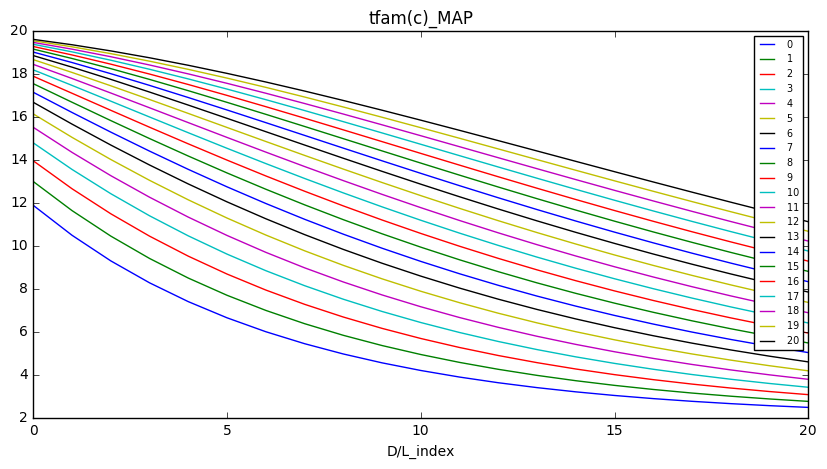

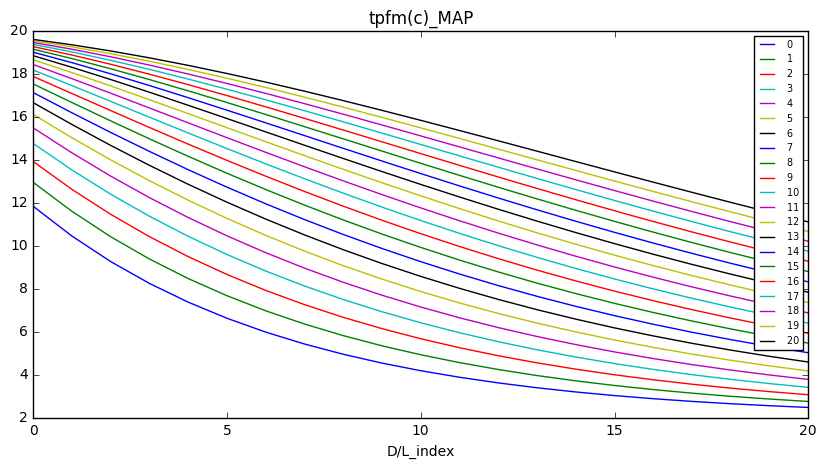

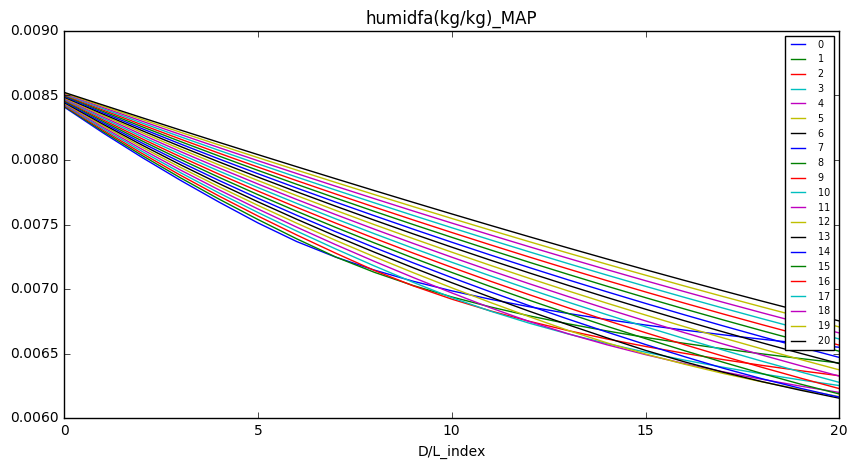

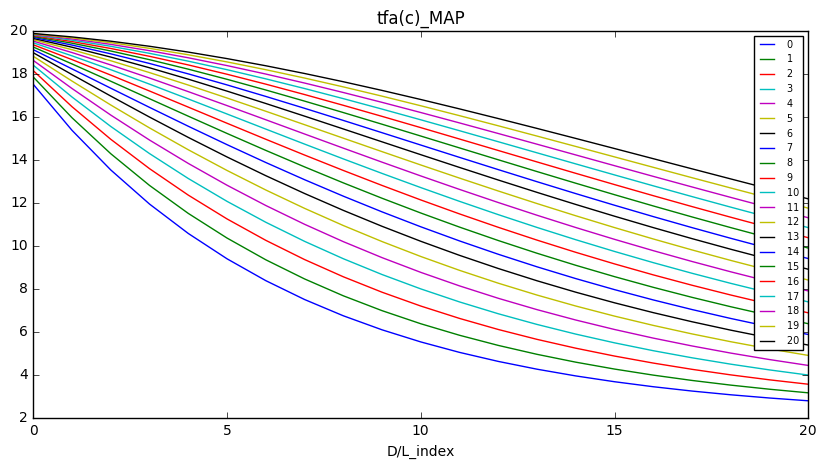

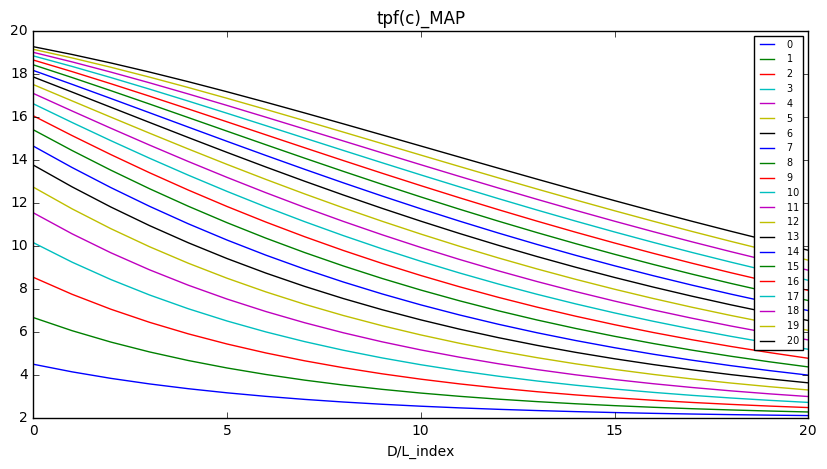

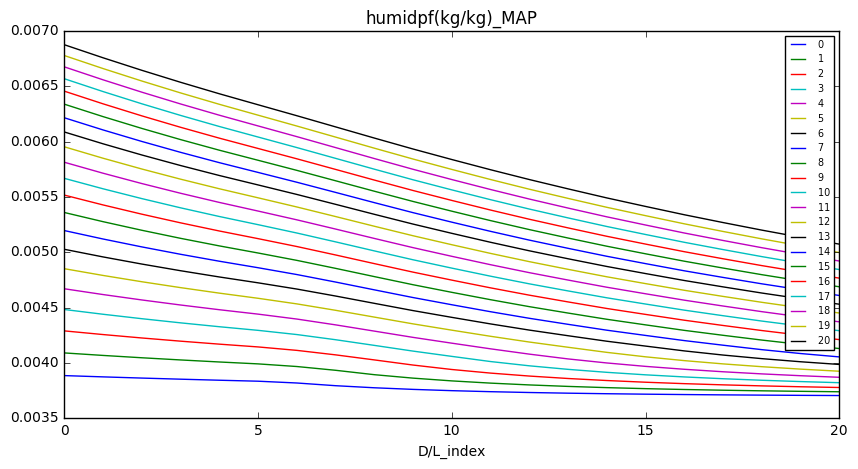

In [126]:
for i in profiles.keys():
    profiles[i].plot(figsize=(10,5))
    plt.title(i)
    plt.legend(fontsize='x-small')


In [127]:
# compute output profile statistics
means = []
mins  = []
maxs  = []
stdev = []
for i in profiles.keys():
    means.append(profiles[i].tail(1).values.mean())
    mins.append(profiles[i].tail(1).values.min())
    maxs.append(profiles[i].tail(1).values.max())
    stdev.append(profiles[i].tail(1).values.std())
result = pd.DataFrame([means, mins, maxs,stdev], index =['Mean out','Min out','Max out', 'Stdev out'], columns = profiles.keys())


In [128]:
result

,tfam(c)_MAP,tpfm(c)_MAP,humidfa(kg/kg)_MAP,tfa(c)_MAP,tpf(c)_MAP,humidpf(kg/kg)_MAP
Mean out,6.566775,6.559782,0.006399,7.434143,5.485389,0.004323
Min out,2.508980,2.506550,0.006156,2.815900,2.129200,0.003706
Max out,11.134100,11.125400,0.006754,12.195700,9.808060,0.005074
Stdev out,2.699630,2.697783,0.000187,2.922886,2.425307,0.000436


## Density plots

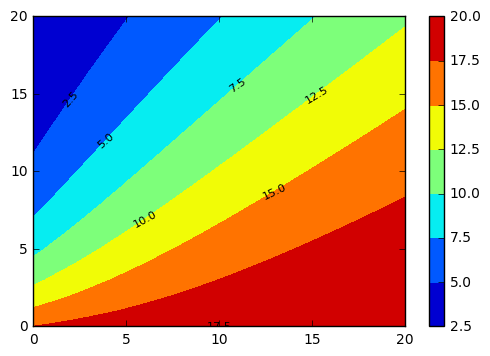

In [129]:
contour = plt.contourf(profiles['tfa(c)_MAP'])
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=8)
plt.colorbar()

c:\python27\lib\site-packages\matplotlib\contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


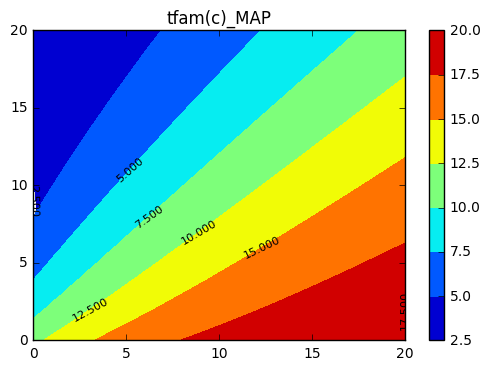

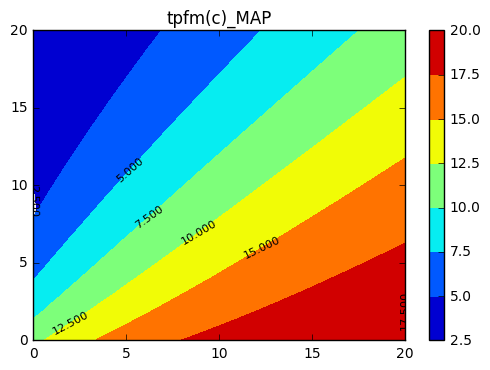

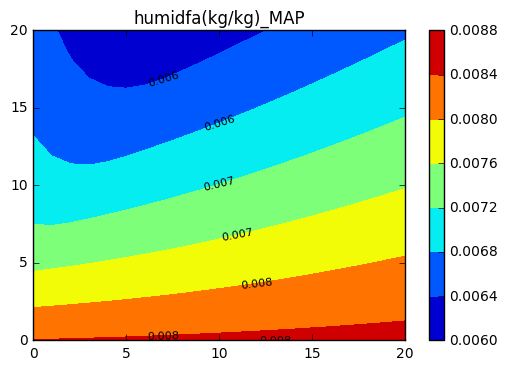

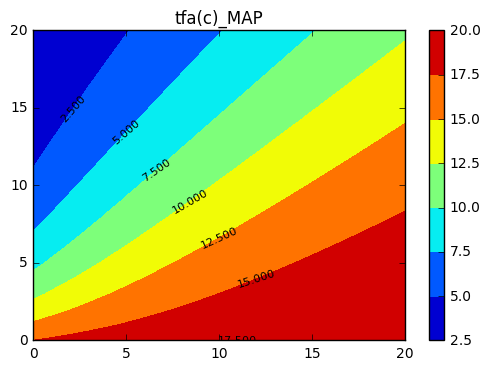

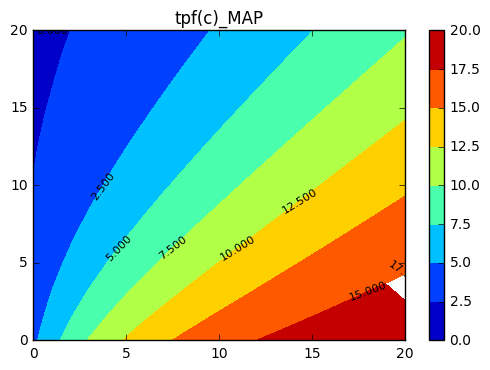

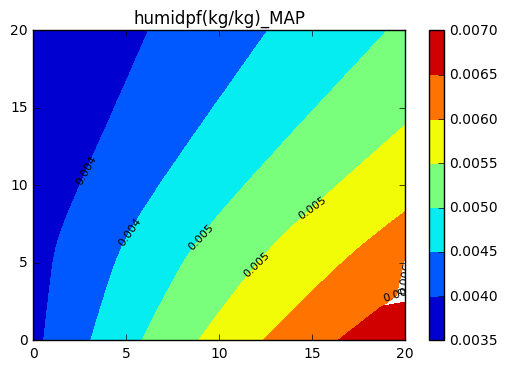

In [130]:
for i in profiles.keys():
    plt.figure(i)
    contour = plt.contourf(profiles[i])
    plt.clabel(contour, colors = 'k',  fontsize=8)
    plt.colorbar()
    plt.title(i)


# Water Condensation Zone

Water condensation happens when humid air reaches the dew point.
Here below a variable Dew Proxymity will be defined as the actual difference between the temperature and the dew point: water condensation happens when $ Dew_{proxy} < 0 $ .

$ Dew_{proxy} = T - T_{dp} $


In [131]:
def Pws(T):   # Saturated water in [Pa], T [K]
    c1=-7.85951783
    c2= 1.84408259
    c3=-11.7866497
    c4=22.6807411
    c5=-15.9618719
    c6=1.80122502
    Tc = 647.096  # Temperatura critica acqua [K]
    th = 1. - (T / Tc)
    lhs = Tc / T * (c1*th+c2*th**1.5 + c3*th**3 + c4*th**3.5+
                    c5*th**4 + c6*th**7.5)
    Pc = 22064000 # Pressione critica acqua [Pa]
    Pws = np.exp(lhs) * Pc
    return Pws

def Tdew(T, RH): # T [K] , RH [0 - 100]
    Pw = Pws(T) /100 * RH/100
    A = 6.1162;  m = 7.5892 ; Tn = 240.71      
    Tdew = Tn / (m/np.log10( Pw/ A) -1) +273.15
    return Tdew
def X_(T, RH, Patm): #  Mixing Ratio gH2O/kgAS -> T [K] , RH [0 - 100], Patm [Pa]
    B = 621.9907
    Pw = Pws(T)* RH/100
    X = B * Pw / (Patm - Pw)
    return X

def XTD(Tdew, Patm):   # [Patm] = Pa
    A = 6.1162;  m = 7.5892 ; Tn = 240.71   
    c = 10 **(m/(Tn/Tdew+1))
    B= 621.9907
    return A * B * c/(Patm/100 - A*c)

def TdewX(X, Patm):   # [Patm] = Pa
    A = 6.1162;  m = 7.5892 ; Tn = 240.71   
    B= 621.9907
    c = X * Patm/100/(A*(B+X))
    return Tn/(m/np.log10(c)-1)    

def H(T, X):       # Entalpia kJ / kg, T [K]
    h = (T-273.15)*(1.01 + 0.00189 * X) + 2.5 * X
    return h

In [143]:
DewPoint_a = TdewX(profiles['humidfa(kg/kg)_MAP'] *1000, 113500)
DewPoint_p = TdewX(profiles['humidpf(kg/kg)_MAP'] *1000, 113500)
DewProxy_a = profiles['tfa(c)_MAP'] - DewPoint_a
DewProxy_p = profiles['tpf(c)_MAP'] - DewPoint_p

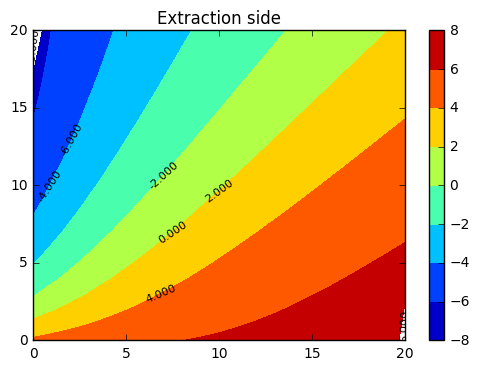

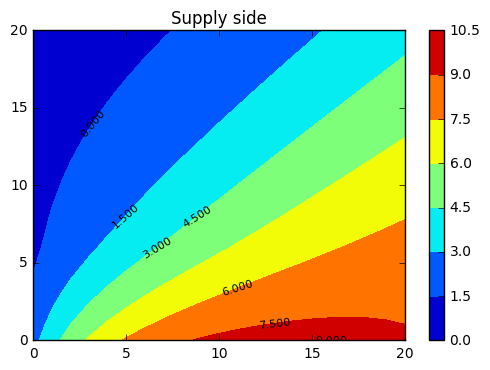

In [144]:
plt.figure()
contour = plt.contourf(DewProxy_a)
plt.clabel(contour, colors = 'k',  fontsize=8)
plt.colorbar()
plt.title('Extraction side')
plt.figure()
contour = plt.contourf(DewProxy_p)
plt.clabel(contour, colors = 'k',  fontsize=8)
plt.colorbar()
plt.title('Supply side')